In [33]:
"""This script performs all of the basic data cleaning for data in the NDBC model building database

This includes reformatting data values, analysis of gaps and nan streaks, imputation, dropping unwanted columns, 

"""

import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
from datetime import datetime
from datetime import timedelta

In [34]:
#little function for outputing the number of missing values for each column
def get_nan_count(df):
    """Outputs the total number of null values in each column

    Args:
            df (dataframe): Any dataframe
    """
    
    missing_values_count = df.isnull().sum()
    print(missing_values_count)


In [35]:
# Quick function for outputing information on a streak of NaN values (e.g. the date range and number of rows over which a sensor was down)
def get_nan_streaks(df_in, column, streak_threshold, verbose=True):
    """Prints a list of the streaks of NaN values in the data(e.g. the date range and number of rows over which a sensor was down)

    Args:
            df_in (dataframe): The dataframe of interest
            column (str): The column in the dataframe for which you want streak data
            streak_threshold (int):the minimum number of sequential NaN over which the streak will be reported
            verbose (bool): (default false) if true the function will print out a line of info for each streak 

    Returns:
            List: [[streak count[int], streak(int): number of nans in streak, start_date(datetime obj): for streak, end_date: for streak]]
    """

    #copy the df so we are not modifying in place
    df=df_in.copy(deep=True)
    #info for each individual streak
    streak=0 
    start_date=0
    end_date=0 
    #Count the total number of streaks
    streak_count=0
    streak_info_matrix=[]
    #Loop through every row in the df
    for i in range(1, len(df)-1):
        #If the value in the row is NaN and the previous value is not we start a streak
        if pd.isna(df[column].iloc[i]) and pd.isna(df[column].iloc[i-1])==False:
            streak+=1
            start_date=df['date'].iloc[i]
        #IF the value and the surounding values are NaN we continue incrementing the streak
        if pd.isna(df[column].iloc[i]) and pd.isna(df[column].iloc[i-1]) and pd.isna(df[column].iloc[i+1]):
            streak+=1
        #If the value is NaN and the next value is not we end the streak
        if pd.isna(df[column].iloc[i]) and pd.isna(df[column].iloc[i+1])==False:
            streak+=1 
            end_date=df['date'].iloc[i]
            #If the number of NANs in the streak is above the threshold we record and (optionally) print the streak info
            if streak>streak_threshold:
                streak_count+=1
                if verbose==True:
                    print(f'{streak_count-1}: NaN streak in {column} for {streak} rows from {start_date} to {end_date}')
                streak_info_matrix.append([streak_count-1,streak, start_date, end_date])
            #Reinitialize the streak parameters since we are at the end of the streak
            streak=0 
            start_date=0
            end_date=0
    #Fianlly print the summary data giving the total number of nan streaks
    print(f'SUMMARY: The number of streaks with over {streak_threshold} missing values is {streak_count}')
    return streak_info_matrix




In [36]:
# Funciton to get gaps in data (i.e. dates that were not reported)

def get_data_gaps(df_in, tamedelta_threshold):
    """Prints a list of gaps in the data (i.e. time ranges over which no data is reported)

    Args:
            df_in (dataframe): The dataframe of interest
            tamedelta_threshold (datetime time delta obj): the minimum time gap over which the function will return info on the gap
    """

    #copy the df so that it is not modified in place
    df=df_in.copy(deep=True)
    #loop through each row in the df ind print info for gap if the date diff between previous index and curr index is larger than threshold
    for i in range(1,len(df)):
        start_date=df['date'].iloc[i-1]
        end_date=df['date'].iloc[i]
        if (end_date-start_date)>tamedelta_threshold:
            print(f'Gap in data from {start_date} to {end_date}')

    

In [37]:
# Funciton to recognize NaN values (most stations report errors/NaN values as "99..")
# Also convert all parameters to floats

def nines_to_nans(df_in, data_columns):
    """takes in a dataframe and a list of columns and turns values into NaNs if the value is close to the error value (generally 99..)

    Args:
            df_in (dataframe): The dataframe of interest
            column (List[str]): The columns in the dataframe that have 99.. as data entries to represent nan values

    Returns:
            df (dataframe): new dataframe with nans in place of 99...
    """
    #Copy the dataframe so we arenot modifying in place
    df=df_in.copy(deep=True)
    #loop through all columns in list of columns
    for column in data_columns:
        #change string column values to numeric
        df[column] = pd.to_numeric(df[column], errors='coerce')
        #Cast each column as a float
        df[column] = df[column].astype(float)
        #Here we change the value to NaN if it is close to the max value which is likely 99..
        #And we check to make sure that the max value is in fact 99..
        max_value=max(df[column])
        if '99' in str(max_value):
            df[column]=df[column].apply(lambda x: np.NaN if x>max_value-1 else x)
    
    return df

In [38]:
def impute_from_different_station(df_in, df_filler, column):
    """Function to fill in NaN values with values from the same time but from a different staiton (different df)

    Args:
            df_in (dataframe): The dataframe with nan values that need to be filled
            df_filler (dataframe): Dataframe of data from another similar station
            column (List[str]): The columns in the dataframe for wich nan values will be impputed from another station

    Returns:
            df (dataframe): new dataframe with nan values imputed from different station
    """

    #make a copy of the dataframe so that it is not modified in place
    df=df_in.copy(deep=True)
    #Get the date up to the hour from the filler dataframe
    dates=[datetime.fromisoformat(date_val).strftime("%d-%m-%y-%H") for date_val in df_filler['date'].values]
    #loop through each row in the dataframe
    for i in range(len(df)):
        #if the value is null
        if pd.isna(df[column].iloc[i]):
            #We get the date up to the hour of the row
            fill_date=df['date'].iloc[i]
            fill_date=fill_date.strftime("%d-%m-%y-%H")
            filler_index=0
            #if the date up to the hour that we want to fill is in the filler df
            if fill_date in dates:
                #we get the index of the row in the filler df that matches our nan value
                filler_index=dates.index(fill_date)     
                #Locate the data value and impute it for our nan value
                filler_value=df_filler[column].iloc[filler_index]
                df[column].iloc[i]=filler_value
    return df



In [39]:
#Query raw data from SQLite model building DB
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_raw = pd.read_sql_query("SELECT * FROM NDBC_historical_raw_data", conn, index_col=None)


In [40]:
#format the date column as a datetime object
df_raw["date"] = pd.to_datetime(df_raw["date"])
#specify all of the columns with weather data
data_columns=['PRES', 'DEWP', 'WTMP', 'MWD', 'ATMP',  'WDIR','VIS', 'APD', 'DPD', 'WVHT', 'GST', 'WSPD']
#create a new df that will hold our cleaned data
df_cleaned=df_raw.copy(deep=True)
#Use our function to convert 99.. error values to NaN values 
df_raw=nines_to_nans(df_raw, data_columns)
df_cleaned=nines_to_nans(df_cleaned, data_columns)

<AxesSubplot:xlabel='date'>

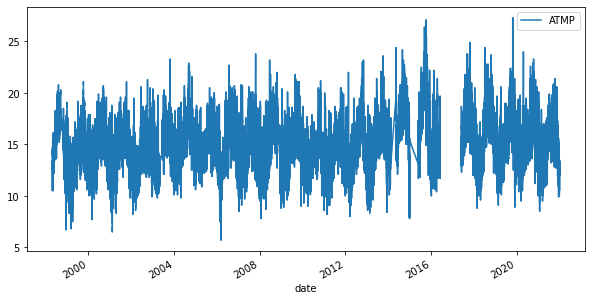

In [41]:
#Plot our raw data 
df_raw.plot(x="date", y=['ATMP'],kind="line", figsize=(10, 5))

#We can see below that the data has both gaps and streaks of nan values

In [42]:
#Get the number of nan vlaues for each column
get_nan_count(df_cleaned)

index          0
year           0
month          0
day            0
hour           0
WDIR        2463
WSPD        1969
GST         3078
WVHT      300403
DPD       300407
APD       300399
MWD       375937
PRES        6386
ATMP       53213
WTMP       51780
DEWP      220607
VIS       488253
minute         7
TIDE       18619
date           7
dtype: int64


In [43]:
#Drop columns with too many nans and columns that we dont need
df_cleaned['datetime']=df_cleaned['date']
df_cleaned=df_cleaned.drop(columns=['TIDE', 'VIS', 'DEWP', 'MWD', 'APD', 'DPD','WVHT', 'index', 'year', 'month', 'day', 'hour', 'minute'])
df_cleaned = df_cleaned.dropna(subset=['datetime'])
#set our index to a datetime index (note we also keed a seperate column with our datetime object for convenience)
df_cleaned=df_cleaned.set_index('datetime')


In [44]:
#Information for streaks of nan values in the data using our nines to nans function defined above
WTMP_streak_info=get_nan_streaks(df_cleaned, 'WTMP', 30)

0: NaN streak in WTMP for 31 rows from 1998-09-25 13:00:00 to 1998-10-27 19:00:00
1: NaN streak in WTMP for 480 rows from 2016-06-23 00:00:00 to 2016-06-26 07:50:00
2: NaN streak in WTMP for 47932 rows from 2016-06-26 08:30:00 to 2017-05-25 17:30:00


KeyboardInterrupt: 

In [ ]:
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 30)

0: NaN streak in ATMP for 31 rows from 1998-09-25 13:00:00 to 1998-10-27 19:00:00
1: NaN streak in ATMP for 695 rows from 2003-05-08 15:00:00 to 2003-06-06 13:00:00
2: NaN streak in ATMP for 50808 rows from 2016-06-06 09:10:00 to 2017-05-25 17:30:00
SUMMARY: The number of streaks with over 30 missing values is 3


In [45]:
#Use our function defined above to get information on gaps in the data
get_data_gaps(df_cleaned, timedelta(hours=24))

Gap in data from 1998-05-05 23:00:00 to 1998-05-07 00:00:00
Gap in data from 1998-08-29 23:00:00 to 1998-09-19 00:00:00
Gap in data from 1998-09-25 23:00:00 to 1998-10-27 00:00:00
Gap in data from 2008-11-03 22:50:00 to 2008-12-04 17:50:00
Gap in data from 2014-02-17 10:50:00 to 2014-05-14 22:50:00
Gap in data from 2014-12-31 22:50:00 to 2015-05-21 16:30:00
Gap in data from 2017-05-30 05:10:00 to 2017-05-31 07:30:00
Gap in data from 2021-03-09 17:40:00 to 2021-03-15 16:00:00


In [ ]:
#Choose a stretch of data for our cleaned data set that does not contain any major gaps or streaks
df_cleaned=df_cleaned[(datetime.fromisoformat('2003-06-06 13:00:00')<df_cleaned['date']) & (df_cleaned['date']<datetime.fromisoformat('2014-02-17 10:50:00'))]

In [ ]:
get_nan_count(df_cleaned)

WDIR    545
WSPD     27
GST     173
PRES    117
ATMP     67
WTMP    151
date      0
dtype: int64


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92634 entries, 2003-06-06 14:00:00 to 2014-02-17 09:50:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    92089 non-null  float64       
 1   WSPD    92607 non-null  float64       
 2   GST     92461 non-null  float64       
 3   PRES    92517 non-null  float64       
 4   ATMP    92567 non-null  float64       
 5   WTMP    92483 non-null  float64       
 6   date    92634 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.7 MB


In [ ]:
#get data gap and streak info for our newly cleaned dataset
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 2)

0: NaN streak in ATMP for 6 rows from 2003-09-20 05:00:00 to 2003-09-20 10:00:00
SUMMARY: The number of streaks with over 2 missing values is 1


In [ ]:
get_data_gaps(df_cleaned, timedelta(hours=24))

Gap in data from 2008-11-03 22:50:00 to 2008-12-04 17:50:00


In [ ]:
#We only have some small streaks so we just fill these with simple linear interpoation
df_cleaned = df_cleaned.interpolate(method='linear', axis=0).ffill().bfill()

In [ ]:
get_nan_count(df_cleaned)

WDIR    0
WSPD    0
GST     0
PRES    0
ATMP    0
WTMP    0
date    0
dtype: int64


In [ ]:
#To convert our data gaps to nan values we use the resample function but resample as hours (even thought the df is already in hours)
df_cleaned = df_cleaned.resample("H").mean()

In [ ]:
#We have now created a few more streaks of nan values by filling in our data gaps
df_cleaned['date']=df_cleaned.index
get_nan_count(df_cleaned)
get_data_gaps(df_cleaned, timedelta(hours=24))
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 2)

WDIR    1179
WSPD    1179
GST     1179
PRES    1179
ATMP    1179
WTMP    1179
date       0
dtype: int64
0: NaN streak in ATMP for 4 rows from 2007-02-17 12:00:00 to 2007-02-17 15:00:00
1: NaN streak in ATMP for 3 rows from 2007-02-19 19:00:00 to 2007-02-19 21:00:00
2: NaN streak in ATMP for 3 rows from 2007-03-05 19:00:00 to 2007-03-05 21:00:00
3: NaN streak in ATMP for 4 rows from 2007-03-20 22:00:00 to 2007-03-21 01:00:00
4: NaN streak in ATMP for 6 rows from 2007-10-10 13:00:00 to 2007-10-10 18:00:00
5: NaN streak in ATMP for 738 rows from 2008-11-03 23:00:00 to 2008-12-04 16:00:00
6: NaN streak in ATMP for 11 rows from 2008-12-07 01:00:00 to 2008-12-07 11:00:00
7: NaN streak in ATMP for 3 rows from 2010-01-04 20:00:00 to 2010-01-04 22:00:00
8: NaN streak in ATMP for 4 rows from 2010-09-07 21:00:00 to 2010-09-08 00:00:00
SUMMARY: The number of streaks with over 2 missing values is 9


In [ ]:
#IMPUTING DATA VALUES USING A SEPERATE CLOSE BY STATION
#Query raw data from DB for our other station
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_raw_westSB = pd.read_sql_query("SELECT * FROM NDBC_historical_raw_data_St46054", conn, index_col=None)

# Conduct some basic cleaning on the dataframe
data_columns=['PRES', 'DEWP', 'WTMP', 'MWD', 'ATMP',  'WDIR','VIS', 'APD', 'DPD', 'WVHT', 'GST', 'WSPD']
df_cleaned_westSB=df_raw_westSB
df_cleaned_westSB=nines_to_nans(df_cleaned_westSB, data_columns)
df_cleaned_westSB=df_cleaned_westSB.dropna(subset=['date'])
get_nan_count(df_cleaned_westSB)

index          0
year           0
month          0
day            0
hour           0
WDIR       56740
WSPD       13456
GST        20274
WVHT      202427
DPD       202523
APD       202427
MWD       308500
PRES       17599
ATMP      110256
WTMP       80305
DEWP      253578
VIS       376549
minute         0
TIDE       22651
date           0
dtype: int64


In [ ]:
#Plot the station data to visualize its gaps and streaks
#df_cleaned_westSB.plot(x="date", y=['WTMP'],kind="line", figsize=(10, 5))

In [26]:
#Use our function defined above to impute values from our filler station
df_cleaned=impute_from_different_station(df_cleaned, df_cleaned_westSB, 'PRES')
df_cleaned=impute_from_different_station(df_cleaned, df_cleaned_westSB, 'ATMP')
df_cleaned=impute_from_different_station(df_cleaned, df_cleaned_westSB, 'WTMP')

C:\Users\dakot\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [27]:
#We will still have some nan values because we did not impute for every column and the filler data will have nan values too
get_nan_count(df_cleaned)
get_data_gaps(df_cleaned, timedelta(hours=24))
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 2)

WDIR    1179
WSPD    1179
GST     1179
PRES     185
ATMP     157
WTMP     194
date       0
dtype: int64
0: NaN streak in ATMP for 3 rows from 2008-11-04 10:00:00 to 2008-11-04 12:00:00
1: NaN streak in ATMP for 5 rows from 2008-11-04 21:00:00 to 2008-11-05 01:00:00
2: NaN streak in ATMP for 4 rows from 2008-11-05 03:00:00 to 2008-11-05 06:00:00
3: NaN streak in ATMP for 3 rows from 2008-11-05 12:00:00 to 2008-11-05 14:00:00
4: NaN streak in ATMP for 3 rows from 2008-11-05 16:00:00 to 2008-11-05 18:00:00
5: NaN streak in ATMP for 6 rows from 2008-11-05 23:00:00 to 2008-11-06 04:00:00
6: NaN streak in ATMP for 4 rows from 2008-11-06 06:00:00 to 2008-11-06 09:00:00
7: NaN streak in ATMP for 3 rows from 2010-01-04 20:00:00 to 2010-01-04 22:00:00
SUMMARY: The number of streaks with over 2 missing values is 8


In [28]:
#Fill in te rest od the values with linear interpolation
df_cleaned = df_cleaned.interpolate(method='linear', axis=0).ffill().bfill()

In [29]:
get_nan_count(df_cleaned)
get_data_gaps(df_cleaned, timedelta(hours=24))
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 2)

WDIR    0
WSPD    0
GST     0
PRES    0
ATMP    0
WTMP    0
date    0
dtype: int64
SUMMARY: The number of streaks with over 2 missing values is 0


<AxesSubplot:xlabel='date'>

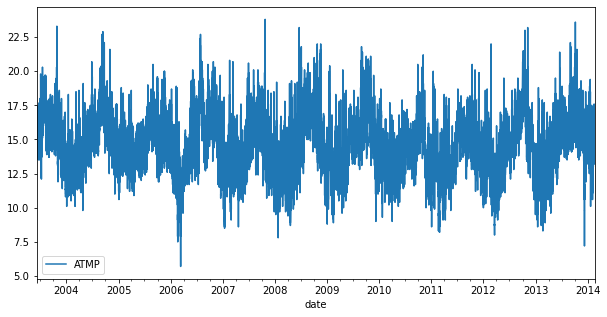

In [30]:
df_cleaned.plot(x="date", y=['ATMP'],kind="line", figsize=(10, 5))

In [31]:
#Save our cleaned dataframe to a new table in our local SQL database
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_cleaned.to_sql(name=f'NDBC_historical_cleaned_data',con=conn,schema='NDBC_model_building_database.db',if_exists='replace') 

In [32]:
#Print out a list of all of the tables in the SQL data frame
con = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('NDBC_historical_raw_data',), ('NDBC_historical_raw_data_St#{STATIONNUMBER}',), ('NDBC_historical_raw_data_St{STATIONNUMBER}',), ('NDBC_historical_raw_data_St46054',), ('NDBC_historical_data_for_training',), ('NDBC_historical_cleaned_data',)]
